In [1]:
import numpy as np
import mltools as ml
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier

In [2]:
Xtr = np.genfromtxt('data/X_train.txt',delimiter=',')
Ytr = np.genfromtxt('data/Y_train.txt',delimiter=',')
Xte = np.genfromtxt('data/X_test.txt',delimiter=',')
Xtr,Ytr = ml.shuffleData(Xtr,Ytr)

Xtr,Xva,Ytr,Yva = ml.splitData(Xtr,Ytr); # split data into 80/20 train/validation
Xtr, Ytr = ml.shuffleData(Xtr, Ytr)

In [3]:
print(Xtr.shape)
print(Ytr.shape)
print(Xva.shape)
print(Xte.shape)

(5938, 107)
(5938,)
(1485, 107)
(7422, 107)


# Linear Classifier

In [58]:
Xtr,params = ml.transforms.rescale(Xtr)
Xva,_ = ml.transforms.rescale(Xva, params)
Xte,_ = ml.transforms.rescale(Xte)

In [59]:
learner = ml.linearC.linearClassify()
learner.train(Xtr, Ytr, reg=0.1, initStep=0.01, stopTol=1e-6, stopIter=100)

In [60]:
sum(learner.predict(Xtr) == Ytr)/Xtr.shape[0]

0.615527113506231

In [61]:
sum(learner.predict(Xva) == Yva)/Xva.shape[0]

0.6067340067340067

Train AUC: 0.6646324548922454
Validation AUC: 0.6660171699359212


array([[0.00000000e+00, 3.83864099e-01],
       [1.00000000e+00, 2.75440124e-01],
       [2.00000000e+00, 5.71073187e-01],
       ...,
       [7.41900000e+03, 4.96726040e-01],
       [7.42000000e+03, 6.66810853e-01],
       [7.42100000e+03, 3.73789676e-01]])

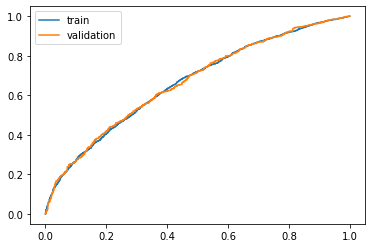

In [20]:
probs = learner.predictSoft(Xte)

ROC1 = learner.roc(Xtr,Ytr)
ROC2 = learner.roc(Xva,Yva)

plt.plot(ROC1[0],ROC1[1],label = 'train')
plt.plot(ROC2[0],ROC2[1],label = 'validation')
plt.legend()

print("Train AUC: " + str(learner.auc(Xtr, Ytr)))
print("Validation AUC: " + str(learner.auc(Xva, Yva)))

Yte = np.vstack((np.arange(Xte.shape[0]), learner.predictSoft(Xte)[:,1])).T

np.savetxt('Y_submit_classifier.txt',Yte,'%d, %.2f',header='ID,Predicted',comments='',delimiter=',')

# Neural Network

In [9]:

model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape = Xtr[1].shape),
        keras.layers.Dense(100, activation='softmax'),
        keras.layers.Dense(100, activation='softmax'),
        keras.layers.Dense(1,activation="sigmoid")
    ]
)

model.compile(
    loss='binary_crossentropy', 
    optimizer = 'adam',
    metrics=["accuracy"],
)

In [10]:
model.fit(Xtr,Ytr,epochs=20,validation_data=(Xva, Yva))

Epoch 1/20
186/186 [==============================] - 1s 4ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6928 - val_accuracy: 0.5071
Epoch 2/20
186/186 [==============================] - 1s 4ms/step - loss: 0.6922 - accuracy: 0.5236 - val_loss: 0.6912 - val_accuracy: 0.5912
Epoch 3/20
186/186 [==============================] - 1s 3ms/step - loss: 0.6893 - accuracy: 0.5899 - val_loss: 0.6874 - val_accuracy: 0.6013
Epoch 4/20
186/186 [==============================] - 1s 5ms/step - loss: 0.6841 - accuracy: 0.6095 - val_loss: 0.6821 - val_accuracy: 0.6081
Epoch 5/20
186/186 [==============================] - 1s 4ms/step - loss: 0.6770 - accuracy: 0.6192 - val_loss: 0.6762 - val_accuracy: 0.6040
Epoch 6/20
186/186 [==============================] - 1s 4ms/step - loss: 0.6688 - accuracy: 0.6292 - val_loss: 0.6709 - val_accuracy: 0.6034
Epoch 7/20
186/186 [==============================] - 1s 4ms/step - loss: 0.6606 - accuracy: 0.6364 - val_loss: 0.6652 - val_accuracy: 0.6101
Epoch 

In [24]:
Yte = model.predict(Xte)
Yte = np.vstack((np.arange(Xte.shape[0]),Yte[:,0])).T
np.savetxt('Y_submit_NN.txt',Yte,'%d, %.2f',header='ID,Predicted',comments='',delimiter=',')

# Decision Tree

In [25]:
learner = ml.dtree.treeClassify(Xtr,Ytr)

In [26]:
Ytr_pred = learner.predict(Xtr)
Yva_pred = learner.predict(Xva)
print(f'Training error rate: {sum(Ytr_pred != Ytr)/len(Ytr)}')
print(f'Validation error rate: {sum(Yva_pred != Yva)/len(Yva)}')

Training error rate: 0.0
Validation error rate: 0.3744107744107744


In [27]:
train_error_list = []
validation_error_list = []
for i in range(8):
    learner = ml.dtree.treeClassify(Xtr,Ytr,maxDepth = i)
    Ytr_pred = learner.predict(Xtr)
    Yva_pred = learner.predict(Xva)
    train_error_list.append(sum(Ytr_pred != Ytr)/len(Ytr))
    validation_error_list.append(sum(Yva_pred != Yva)/len(Yva))


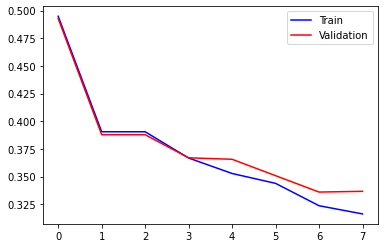

In [28]:
plt.plot(train_error_list,'b-',label = 'Train')
plt.plot(validation_error_list,'r-',label = 'Validation')
plt.legend()

In [29]:
train_error_list = []
validation_error_list = []
for i in range(14):
    learner = ml.dtree.treeClassify(Xtr,Ytr,maxDepth = 5, minParent = 2**i)
    Ytr_pred = learner.predict(Xtr)
    Yva_pred = learner.predict(Xva)
    train_error_list.append(sum(Ytr_pred != Ytr)/len(Ytr))
    validation_error_list.append(sum(Yva_pred != Yva)/len(Yva))

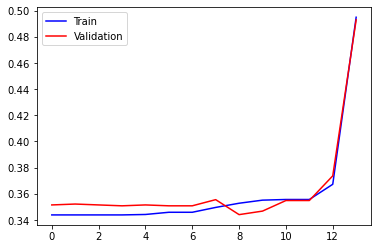

In [30]:
plt.plot(train_error_list,'b-',label = 'Train')
plt.plot(validation_error_list,'r-',label = 'Validation')
plt.legend()

In [31]:
train_error_list = []
validation_error_list = []
for i in range(1,14):
    learner = ml.dtree.treeClassify(Xtr,Ytr,maxDepth = 5, minLeaf = 2**i,minParent =32)
    Ytr_pred = learner.predict(Xtr)
    Yva_pred = learner.predict(Xva)
    train_error_list.append(sum(Ytr_pred != Ytr)/len(Ytr))
    validation_error_list.append(sum(Yva_pred != Yva)/len(Yva))

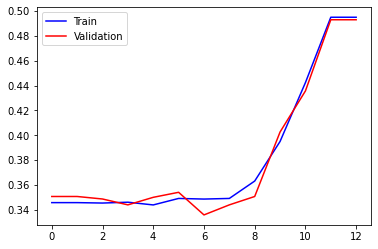

In [32]:
plt.plot(train_error_list,'b-',label = 'Train')
plt.plot(validation_error_list,'r-',label = 'Validation')
plt.legend()

In [55]:
learner = ml.dtree.treeClassify(Xtr,Ytr,maxDepth = 5,minParent =32,minLeaf = 8)

In [56]:
sum(learner.predict(Xtr) == Ytr)/Ytr.shape[0]

0.6544291007073089

In [57]:
sum(learner.predict(Xva) == Yva)/Yva.shape[0]

0.6511784511784512

Train AUC: 0.7249525502489714
Validation AUC: 0.7251068585403379


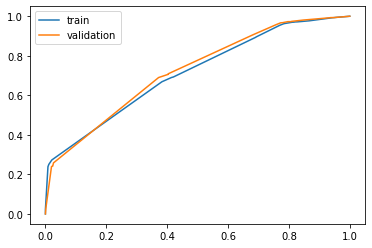

In [34]:
Ytr_pred = learner.predict(Xtr)
Yva_pred = learner.predict(Xva)
ROC1 = learner.roc(Xtr,Ytr)
ROC2 = learner.roc(Xva,Yva)

plt.plot(ROC1[0],ROC1[1],label = 'train')
plt.plot(ROC2[0],ROC2[1],label = 'validation')
plt.legend()

print("Train AUC: " + str(learner.auc(Xtr, Ytr)))
print("Validation AUC: " + str(learner.auc(Xva, Yva)))

Yte = np.vstack((np.arange(Xte.shape[0]), learner.predictSoft(Xte)[:,1])).T

np.savetxt('Y_submit_tree.txt',Yte,'%d, %.2f',header='ID,Predicted',comments='',delimiter=',')

# Bagged Decision Tree

In [64]:
nbags = 50
ensemble = []
Yte_pred = np.zeros((1,np.size(Xte,0)))
for i in range(nbags):
    Xb,Yb = ml.bootstrapData(Xtr,Ytr)
    ensemble.append(ml.dtree.treeClassify(Xb,Yb))
    Yte_pred += ensemble[i].predict(Xte)
Yte_pred /= nbags

In [37]:
Yte = np.vstack((np.arange(Xte.shape[0]),Yte_pred)).T

In [38]:
np.savetxt('Y_submit_bag2.txt',Yte,'%d, %.2f',header = 'Id,Predicted',comments = '',delimiter = ',')

In [66]:
nbags = 50
ensemble = []
Ytr_pred = np.zeros((1,np.size(Xtr,0)))
for i in range(nbags):
    Xb,Yb = ml.bootstrapData(Xtr,Ytr)
    ensemble.append(ml.dtree.treeClassify(Xb,Yb))
    Ytr_pred += ensemble[i].predict(Xtr)
Ytr_pred /= nbags
for i in range(Ytr_pred.shape[1]):
    if Ytr_pred[0,i] >= 0.5:
        Ytr_pred[0,i] = 1
    elif Ytr_pred[0,i] <= 0.5:
        Ytr_pred[0,i] = 0
print(sum(Ytr_pred == Ytr)/Ytr_pred.shape[1])

[0.00016841 0.00016841 0.00016841 ... 0.00016841 0.00016841 0.00016841]


In [76]:
sum(Ytr_pred[0] == Ytr)/ Ytr.shape[0]
#print(sum(Ytr_pred[0] == Ytr)/Ytr.shape[1])

1.0

In [77]:
nbags = 50
ensemble = []
Yva_pred = np.zeros((1,np.size(Xva,0)))
for i in range(nbags):
    Xb,Yb = ml.bootstrapData(Xtr,Ytr)
    ensemble.append(ml.dtree.treeClassify(Xb,Yb))
    Yva_pred += ensemble[i].predict(Xva)
Yva_pred /= nbags
for i in range(Yva_pred.shape[1]):
    if Yva_pred[0,i] >= 0.5:
        Yva_pred[0,i] = 1
    elif Yva_pred[0,i] <= 0.5:
        Yva_pred[0,i] = 0
print(sum(Yva_pred[0] == Yva)/Yva.shape[0])

0.6606060606060606


# Random Forest

In [4]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=50,
                                       n_estimators=100, oob_score=True)

In [5]:
classifier_rf.fit(Xtr,Ytr)

RandomForestClassifier(max_depth=50, n_jobs=-1, oob_score=True, random_state=42)

In [6]:
sum(classifier_rf.predict(Xtr) == Ytr)/Ytr.shape[0]

1.0

In [7]:
sum(classifier_rf.predict(Xva) == Yva)/Yva.shape[0]

0.6579124579124579

In [8]:
Yte = np.vstack((np.arange(Xte.shape[0]),classifier_rf.predict(Xte))).T
np.savetxt('Y_submit_random_forest.txt',Yte,'%d, %.2f',header = 'Id,Predicted',comments = '',delimiter = ',')